# Cración de un índice invertido
Por: Eric S. Tellez <eric.tellez@infotec.mx>



## Introducción

Un índice invertido es una estructura de búsqueda por contenido de texto u otros datos que pueden ser representados mediante símbolos. Será el centro de este curso crear los algoritmos necesarios para implementar un índice invertido.

En la presente práctica relativa a búsqueda en arreglos ordenados utilizaremos la estructura interna (arreglos ordenados) generada por un índice invertido para una colección de texto. Para eso utilizaremos el índice invertido definido del paquete [TextSearch](https://github.com/sadit/TextSearch.jl).

El código básico se encontrará a lo largo de este notebook.


## Creando un índice invertido

Crearemos un índice invertido usando 50'000 tweets públicos y reales, de contenido político. No hubo ningún tipo de censura en los textos, por lo cual se recomienda discreción. Los tweets fueron colectados durante epoca de la campaña presidencial 2018. Note que se puede usar cualquier conjunto de mensajes en el directorio _datos_ de este repositorio.

El formato original de los datos son mensajes en formato [JSON](https://es.wikipedia.org/wiki/JSON), provenientes del stream público de Twitter. El archivo que se utilizará contiene un tweet por linea, es decir, cada linea es un JSON valido.

La idea por el momento es crear únicamente lo necesario, con la menor cantidad de dependencias. 


## Primeros pasos

Se inicializará el repositorio, así como también cargar los datos

In [1]:
using Pkg
Pkg.activate(".")
# Pkg.instantiate() # solo la primera vez se debe correr
using SimilaritySearch, TextSearch, JSON3

  Activating environment at `~/MCDI2021-ALGO-IR/3. Algoritmos de búsqueda en listas ordenadas/Project.toml`


## Preprocesamiento
La base de datos se lee, un JSON por cada línea. Como segundo paso, debemos convertir el texto a simbolos, estos serán las palabras. Para este proceso, vamos a simplificar el texto y luego crear una bolsa de palabras (la cual es un `multiset`), y para eso se realizarán algunas normalizaciones y procesamientos simples:
- bajar a minúsculas
- se removerán símbolos de puntuación y otros no alfanuméricos
- se removerán acentos
- las urls se agruparan como un único símbolo
- se removerán las palabras comunes (_stopwords_)

Nota: No es el objeto de este curso el procesamiento de lenguaje natural, por lo que no se abordará más que lo esencial para tener la estructura deseada, sin embargo me gustaría investigarán otras funciones y de ser posible, las apliquen.

In [2]:
config = TextConfig(
    del_diac=true,
    del_dup=false,
    del_punc=true,
    group_num=true,
    group_url=true,
    group_usr=false,
    group_emo=false,
    lc=true,
    nlist=[1],
)

function read_corpus(filename)
    corpus = String[]
    for line in eachline(filename)
        d = JSON3.read(line)
        push!(corpus, d["text"])
    end

    corpus
end

STOPWORDS = Set(["de", "la", "el", "a", "y", "en", "que","con", "los", "se", "del", "para", "no", "por", "las", "su", "un", "al", "es",
    "lo", "como", "una", "mas", "le", "si", "ya","esta", "pero", "sobre", "pais",  "entre", "sus", "asi", "tras", "este", "sera", "fue", "via", "son", "dice", "ser",
    "me", "nuevo", "o", "tiene", "sin", "te", "todos", "todo", "ha", "nos", "ahora", "solo", "desde", "les", "hay", 
    "quien", "ni", "mi", "tambien", "hasta", "contra", "porque", "muy", "eso", "habra", "yo",
    "cuando", "bien", "donde", "esto", "pide", "debe", "estos", "vamos", "ante", "e",  "tu", "hace", "hacer", 
    "despues", "nada", "quienes", "antes", "mejor", "parte", "ver"])


function create_invindex(config, corpus)
    corpus_bow = compute_bow(config, corpus)
    for w in STOPWORDS
        delete!(corpus_bow, Symbol(w))
    end
    
    model = VectorModel(FreqWeighting(), corpus_bow)
    (config=config, model=model, index=InvIndex([vectorize(model, compute_bow(config, m)) for m in corpus]))
end


create_invindex (generic function with 1 method)

In [3]:
filename = "../datos/politicos.json"
#filename = "../datos/quejas2020.json"
#filename = "../datos/etiquetadofrontal2020.json"
#filename = "../datos/pcovid2020.json"
corpus = read_corpus(filename)
I = create_invindex(config, corpus)

@info "voc-size: $(length(I.index.lists)), num-messages: $(I.index.n)"


┌ Info: voc-size: 40703, num-messages: 50000
└ @ Main In[3]:8


## Índice Invertido
El índice permite realizar búsquedas

In [4]:
function search_corpus(I, q)
    println("consulta: $q")
    res = search(I.index, vectorize(I.model, compute_bow(I.config, q)), 10)
    for (i, p) in enumerate(res)
        println(i, " - ", round(p.dist, digits=3), " => ", corpus[p.id])
    end
end

search_corpus (generic function with 1 method)

In [5]:
search_corpus(I, "gasto en encuestas")

consulta: gasto en encuestas
1 - 0.423 => Ricardo Anaya fue el candidato que más gastó en encuestas https://t.co/Qiph5YrWSc
2 - 0.529 => Ricardo Anaya fue el candidato que más gastó en encuestas https://t.co/4c1Q50W8yM https://t.co/WQqYxwk5uw
3 - 0.646 => ¿Cuánto se gastó en las #Elecciones2018? https://t.co/I5MMQ39sGz
4 - 0.646 => Es muy positivo que AMLO quiera recortar el gasto público, solo que los recortes que está anunciando no alcanzan para compensar el gasto que quiere aumentar
https://t.co/lleVc4G8qM
5 - 0.646 => ¿Cuánto se gastó en las #Elecciones2018? https://t.co/drokk1IcnG
6 - 0.646 => ¿Cuánto se gastó en las #Elecciones2018? https://t.co/wCm6xCB7ZE
7 - 0.646 => Es muy positivo que AMLO quiera recortar el gasto público, solo que los recortes que está anunciando no alcanzan para compensar el gasto que quiere aumentar
https://t.co/1ABazuJ1Qt
8 - 0.66 => Más de 40mil millones d pesos gasto @FelipeCalderon en promover su imagen pública y la d su gobierno
@EPN gasto más de 70 m

# Obtención de las listas de posteo para realizar la actividad
Como ya se había comentado, un índice invertido es una tabla dispersa de apuntadores (índices) de ocurrencia de la forma $\textsf{palabra} \rightarrow \textsf{lista de documentos}$.
En particular, en la implementación que se uso también guarda un peso, el cual será ignorado en nuestra actividad.

In [6]:
L = collect(I.index.lists)
sort!(L, by=p -> -length(p.second))
length(L)

40703

## Zipf law

Como recordarán, la ley de Zipf aplicada a texto en un lenguaje natural sigue una ley de potencia: pocos términos ocurren muy frecuentemente y muchos ocurren poco. En esta colección es como sigue.

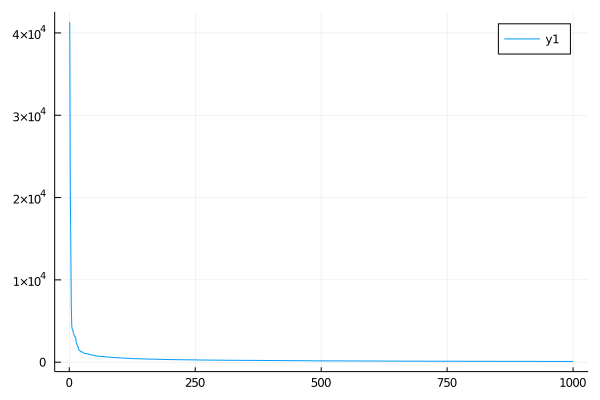

In [8]:
# initialize the plotting library
using Plots
plot([length(x.second) for x in L[1:1000]])

## Partición de los datos para el experimento
Solo se guardarán las 100 listas de posteo más pobladas, con la idea de ser utilizados para caracterizar los algoritmos. Es importante hacer notar que dado el procedimiento, las listas de posteo son generadas a través de un procedimiento real.

In [20]:
open("listas-posteo-100.json", "w") do f
    for i in 1:100
        plist = L[i]
        token = String(I.model.id2token[plist.first])
        list = [e.id for e in plist.second]
        println(token => length(list))
        println(f, JSON3.write((token, list)))
    end
end

"_url" => 41328
"amlo" => 21435
"@lopezobrador_" => 14714
"_num" => 6774
"presidente" => 4380
"mexico" => 3985
"#elecciones_num" => 3916
"pena" => 3610
"#amlo" => 3382
"@epn" => 3202
"gobierno" => 3109
"reunion" => 3080
"nieto" => 2894
"lopez" => 2282
"obrador" => 2222
"triunfo" => 1995
"trump" => 1884
"nacional" => 1824
"#mexico" => 1483
"electo" => 1444
"@inemexico" => 1387
"pompeo" => 1338
"manuel" => 1309
"equipo" => 1296
"transicion" => 1270
"andres" => 1179
"seguridad" => 1137
"gabinete" => 1131
"palacio" => 1112
"virtual" => 1066
"#transicion_num" => 1057
"morena" => 1050
"estado" => 1044
"encuentro" => 1033
"va" => 1027
"presidencial" => 1026
"eleccion" => 1021
"empresarios" => 980
"anos" => 960
"#envivo" => 959
"elecciones" => 921
"campana" => 899
"@ricardoanayac" => 884
"_num%" => 873
"➡" => 864
"votos" => 861
"dijo" => 860
"electoral" => 842
"durante" => 833
"victoria" => 824
"video" => 808
"hoy" => 777
"plan" => 763
"proximo" => 749
"secretario" => 747
"@accionnacional" => 